In [ ]:
!pip install torchinfo
!pip install tensorflow_addons
!pip install tensorflow_text
!pip install -q tf-models-official==2.11.0

In [ ]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from gensim.models import word2vec
from wordcloud import WordCloud, STOPWORDS
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
lemmatizer = WordNetLemmatizer()
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive


# Importing Libraries + Data Preprocessing Steps (same as last notebook)

In [ ]:
data_train=pd.read_csv('/content/drive/MyDrive/train.csv')
data_test=pd.read_csv('/content/drive/MyDrive/test.csv')
process_test=pd.read_csv('/content/drive/MyDrive/processed_test.csv') # obtained after preprocessing / skip preprocessing block
process_train=pd.read_csv('/content/drive/MyDrive/processed_train.csv') # obtained after preprocessing / skip preprocessing block

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/train.csv')
test=pd.read_csv('/content/drive/MyDrive/test.csv')
test_labels=pd.read_csv('/content/drive/MyDrive/test_labels.csv')

In [ ]:
test_set=pd.concat([test['comment_text'],test_labels],axis=1)
test_set=test_set[test_set['toxic']!=-1]

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
process_train=train.copy(deep=True)
process_test=test_set.copy(deep=True)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def isNaN(string):
    return string != string

def text_processing(text):
  text = re.sub(r'[0-9]+',' ', text) #remove all digits
  text=re.sub(r'[^\x00-\x7f]',' ',text) #removes non ascii
  text=text.lower() #lower case
  text= re.sub('http[s]?://\S+', ' ', text) #remove links
  text = re.sub(r'[^\w\s]+',' ',text) #remove punctuations and special characters
  tokens=word_tokenize(text) #tokenizer
  tokens=[word for word in tokens if word not in stop_words] #remove stop words
  tokens=[word for word in tokens if word.isalnum()]#second pass for punctuation and special characters removal
  tokens=[lemmatizer.lemmatize(word) for word in tokens] #lemmatization of word tokens
  text=' '.join(tokens)
  if isNaN(text) or text=='':
    return 'empty'
  return text

process_train['comment_text'] = process_train['comment_text'].apply(text_processing)
process_test['comment_text']=process_test['comment_text'].apply(text_processing)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Exploratory Data Analysis**

The general observation is that the toxic comments wordcloud mostly has swear words like s*ck, f*ck, b*tch etc, the threat wordcloud has words like: d*e, k*ll, which obviously sound threatening enough, the identity hate wordcloud has words like jew, n*gger, g*y, fat which indicates these are the primary words in such comments that our model should be adjusted to condition on.

On the flipside, the non-toxic comments have words like wikipedia, article, talk, please, thank, indicating that the comments otherwise use formal or at least civilized words/


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
Toxic comments word cloud:


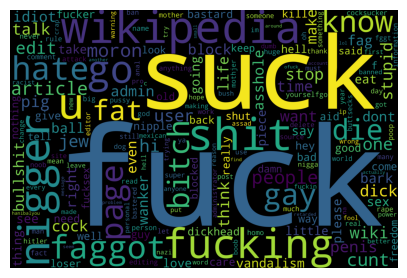

threat comments word cloud:


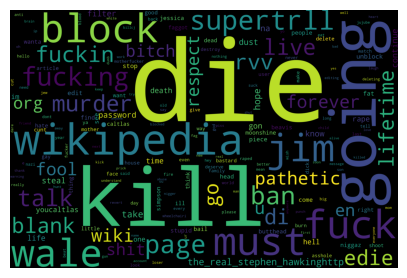

Obscene comments word cloud:


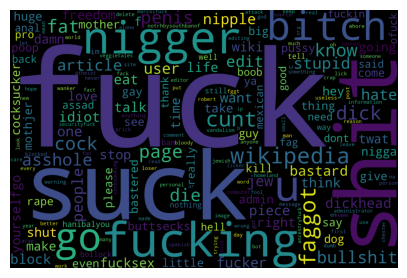

Identity Hate comments word cloud:


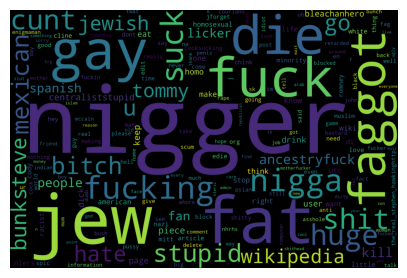

Normal comments word cloud:


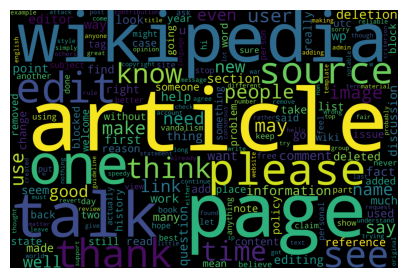

In [ ]:
print(data_train.columns)
toxicWords = data_train.loc[data_train['toxic'] == 1]
toxicWords = toxicWords["comment_text"].tolist()
threatWords = data_train.loc[data_train['threat'] == 1]
threatWords = threatWords["comment_text"].tolist()
ObsceneWords = data_train.loc[data_train['obscene'] == 1]
ObsceneWords = ObsceneWords["comment_text"].tolist()
NormalWords = data_train.loc[data_train['toxic'] == 0]
NormalWords = NormalWords["comment_text"].tolist()
IdentityHateWords = data_train.loc[data_train['identity_hate'] == 1]
IdentityHateWords = IdentityHateWords["comment_text"].tolist()

print("Toxic comments word cloud:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(toxicWords))
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud1)
plt.axis("off");
plt.show()
print("threat comments word cloud:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(threatWords))
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud1)
plt.axis("off");
plt.show()
print("Obscene comments word cloud:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(ObsceneWords))
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud1)
plt.axis("off");
plt.show()
print("Identity Hate comments word cloud:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(IdentityHateWords))
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud1)
plt.axis("off");
plt.show()
print("Normal comments word cloud:")
wordcloud1 = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(NormalWords))
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud1)
plt.axis("off");
plt.show()

**Checking for imbalances (again) in another representation:**

Similar to the last notebook this section seeks to observe the data imbalances. Unlike the bar charts, the pie charts used here provide more insight into the data imbalances (for each class).
Observation: the data is very disproportional, there are not many positive examples for each class, the highest postive examples are for 'toxic', and that too make just 9.6% of the entire dataset.

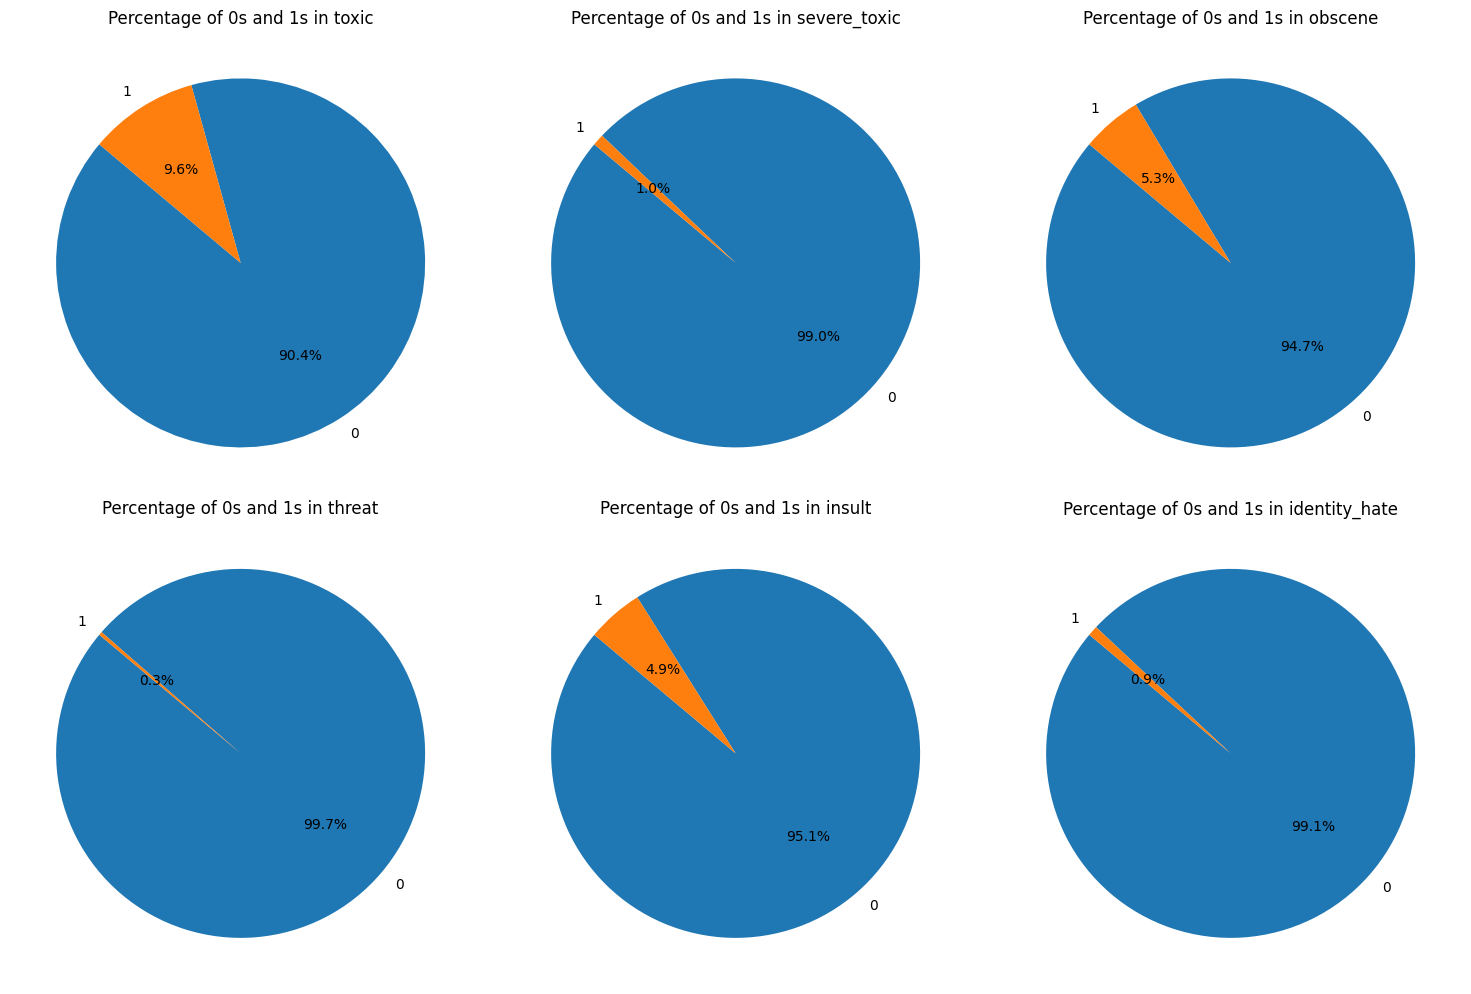

In [ ]:

num_columns = 6  # Number of columns to visualize
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for subplots
for i in range(num_columns):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    counts = traindata.iloc[:, i + 2].value_counts() # Calculate counts for 0s and 1s in the current column
    sizes = counts.values #calculating the percentage
    total = sizes.sum()
    percentages = [(size / total) * 100 for size in sizes]
    ax.pie(percentages, labels=counts.index, autopct='%1.1f%%', startangle=140) # making pie charts
    ax.set_title(f'Percentage of 0s and 1s in {traindata.columns[i+2]}')
plt.tight_layout()
plt.show()

# Generating Balanced Datasets (Relatively Balanced):

Since the RNNs and LSTMS being used are trained for each class in parallel (multi-class multi label prediction) i.e. a many-to-many problem, we formulate a balanced dataset which is not perfectly balanced to a 2:1 ratio like the balanced dataset in the previous notebook. Rather, the different 2:1 proportioned datasets are concatenated to form a combined dataset (which immediately translates into data imbalances within the toxic categories remaining in the resultant set {but hey, it is still better than what we started with}). The same procedure is applied for the test dataset and the high number of non-toxic examples are downsampled.

In [ ]:
ratios=process_train.drop(columns=['comment_text'])
sums=ratios[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum()
balanced_toxic=pd.concat([process_train[process_train['toxic']==1],process_train[process_train['toxic']==0].sample(frac=1).iloc[:int(2*sums['toxic'])]],ignore_index=True).sample(frac=1)
balanced_severe_toxic=pd.concat([process_train[process_train['severe_toxic']==1],process_train[process_train['severe_toxic']==0].sample(frac=1).iloc[:int(2*sums['severe_toxic'])]],ignore_index=True).sample(frac=1)
balanced_obscene=pd.concat([process_train[process_train['obscene']==1],process_train[process_train['obscene']==0].sample(frac=1).iloc[:int(2*sums['obscene'])]],ignore_index=True).sample(frac=1)
balanced_threat=pd.concat([process_train[process_train['threat']==1],process_train[process_train['threat']==0].sample(frac=1).iloc[:int(2*sums['threat'])]],ignore_index=True).sample(frac=1)
balanced_insult=pd.concat([process_train[process_train['insult']==1],process_train[process_train['insult']==0].sample(frac=1).iloc[:int(2*sums['insult'])]],ignore_index=True).sample(frac=1)
balanced_identity_hate=pd.concat([process_train[process_train['identity_hate']==1],process_train[process_train['identity_hate']==0].sample(frac=1).iloc[:int(2*sums['identity_hate'])]],ignore_index=True).sample(frac=1)

balanced_train=pd.concat([balanced_toxic,balanced_severe_toxic,balanced_obscene,balanced_threat,balanced_insult,balanced_identity_hate])
balanced_train=balanced_train[~balanced_train.index.duplicated(keep='first')]

balanced_toxic_test=pd.concat([test_set[test_set['toxic']==1],test_set[test_set['toxic']==0].sample(frac=1).iloc[:int(2*sums['toxic'])]],ignore_index=True).sample(frac=1)
balanced_severe_toxic_test=pd.concat([test_set[test_set['severe_toxic']==1],test_set[test_set['severe_toxic']==0].sample(frac=1).iloc[:int(2*sums['severe_toxic'])]],ignore_index=True).sample(frac=1)
balanced_obscene_test=pd.concat([test_set[test_set['obscene']==1],test_set[test_set['obscene']==0].sample(frac=1).iloc[:int(2*sums['obscene'])]],ignore_index=True).sample(frac=1)
balanced_threat_test=pd.concat([test_set[test_set['threat']==1],test_set[test_set['threat']==0].sample(frac=1).iloc[:int(2*sums['threat'])]],ignore_index=True).sample(frac=1)
balanced_insult_test=pd.concat([test_set[test_set['insult']==1],test_set[test_set['insult']==0].sample(frac=1).iloc[:int(2*sums['insult'])]],ignore_index=True).sample(frac=1)
balanced_identity_hate_test=pd.concat([test_set[test_set['identity_hate']==1],test_set[test_set['identity_hate']==0].sample(frac=1).iloc[:int(2*sums['identity_hate'])]],ignore_index=True).sample(frac=1)

balanced_test=pd.concat([balanced_toxic_test,balanced_severe_toxic_test,balanced_obscene_test,balanced_threat_test,balanced_insult_test,balanced_identity_hate_test])
balanced_test=balanced_test[~balanced_test.index.duplicated(keep='first')]

In [ ]:
balanced_train.shape

(45882, 8)

In [ ]:
balanced_test.shape

(36678, 8)

**Why used pre-trained embeddings?**
>  Using pretrained word embeddings in NLP tasks has become a standard practice in the field, offering numerous advantages. One key benefit is the concept of transfer learning. With pretrained embeddings, a model trained on a large-scale dataset can be utilized for its learned semantic knowledge and fine-tuned on a specific task. In our context, our models benefit from the semantic knowledge captured in pretrained embeddings. Words with similar sentiment tend to have similar vector representations in the embedding space, allowing the model to understand the sentiment of a sentence based on the aggregated sentiment of its constituent words. Even if embeddings are pretrained on a more general domain (for example *'text8'* corpus which we employ for **word2vec** embeddings or the **GLoVe** embeddings from *'glove-wiki-gigaword-300'* may not be specifically trained for sentiment/toxicity analysis), they can still offer valuable word patterns for toxicity. The coming experiments will justify this use.

**Why use sequential models like RNNs and LSTMs for toxicity analysis?**
> Toxicity detection often requires understanding the nuanced and context-dependent nature of offensive language. RNNs, with their recurrent connections, excel in modeling sequential data and preserving information from previous time steps, allowing them to grasp the order and relationships between words in a sentence. Additionally, RNNs are effective in modeling long-term dependencies, which is essential for discerning toxicity patterns where the impact of a word on the toxicity label can extend over an extended context. However, RNNs may fail in very long dependencies and contexts, and here LSTM comes in handy. The architecture of LSTM, which includes memory cells and gating mechanisms, designed to address challenges like the vanishing gradient problem that can hinder the learning of long-range dependencies in vanilla RNNs.
This notebook will explore this power of both RNNs and LSTMs sequentially (pun intended).

# Word2Vec

In [ ]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
corpus = api.load('text8')
w2vmodel = Word2Vec(corpus)

[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
print(f"Vocab size: {len(w2vmodel.wv.key_to_index)}")
print(f"Embedding dimension: {w2vmodel.wv.vectors.shape[1]}")
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(w2vmodel.wv.vectors))

Vocab size: 71290
Embedding dimension: 100


In [ ]:
def word2vec(word):
    return embedding_layer(torch.LongTensor([w2vmodel.wv.key_to_index[word]]))

# GLoVe

In [ ]:
glove = api.load('glove-wiki-gigaword-300') # loading the vectors
print("Found %s word vectors." % len(glove.vectors))

[==================================================] 100.0% 376.1/376.1MB downloaded
Found 400000 word vectors.


In [ ]:
print(f"Vocab size: {len(glove.key_to_index)}")
print(f"Embedding dimension: {glove.vectors.shape[1]}")

Vocab size: 400000
Embedding dimension: 300


Minor observations:
> The glove vectors are higher dimensional (300 vs 100) and trained over a larger vocabulary than the corpus from 'text8'. We expect greater (relevant) information (semantics) to be obtained from the GloVe vectors than the Word2Vec vectors. Hence, our initial assumption is that the GloVe pre-trained embeddings will outpreform the Word2Vec embeddings on both simple RNN and more complex LSTM architectures. We will also include a model with self-trained embedding layer as a comparison to explore the power of pre-trained embeddings.

However, first we tokenize our comments and present them in a format suitable for passing through the embedding layer (as dictated by the weight matrix for each embedding).

After tokenizing all sentences in the training dataset (using TensorFlow's Tokenizer), the tokens are passed to a function where there embedding is generated if they are part of the corpus (if they are not in the pre-training corpus of the embedding, the tokens are assigned random values around 0). The embedding dimension of these random matrix is kept to be the same size as the embedding dimension of the pre-trained embeddings (100 in case of word2vec, 300 for glove).Hence we ensure that all of the tokens in the vocabulary are mapped to an embedding vector of embedding dimensions (300 or 100).The function accumulates the embedded words to avoid redundant queries.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import keras
MAX_LENGTH=100

def get_embedding_matrix(length_voc, word_index, embedding_dim = 100):
    num_tokens = length_voc + 1
    embedded = []
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        if not(word in embedded):
            try:
                embedding_vector = w2vmodel.w2v.get_vector(word)
                embedding_matrix[i] = embedding_vector
            except:
                embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                embedded.append(word)

    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(process_train['comment_text'])
word_index_train = tokenizer.word_index
embedding_matrix_train = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
embedding_dim = w2vmodel.wv.vectors.shape[1]

This code block tokenizes each sentence and pads or truncates it to a certain predefined number of tokens (in this case 100) to ensure same input dimension for each index. The size 100 was chosen since the average token length was 33, and a substantial margin was given to allow for longer sentences, while depreciating exceedingly long sentences.

In [ ]:
print(len(word_index_train.keys()))
NUM_FEATURES = len(word_index_train)
list_tokenized_train = tokenizer.texts_to_sequences(process_train['comment_text'])
lengths = process_train['comment_text'].str.split().apply(len)
MAX_LENGTH = 100
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
Y_train = process_train.drop(columns='comment_text')
Y_train=Y_train.drop(Y_train.columns[0],axis=1).values
train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_set = train_set.cache()
train_set = train_set.shuffle(100000)
train_set = train_set.batch(64)
train = train_set.take(int(0.8*len(train_set)))
val = train_set.skip(int(0.8*len(train_set)))

154469


# Basic Start: Using a simple RNN model with unbalanced training (and testing) data

We start our experiments using basic RNN architectures. The first layer of the RNN model is the embedding layer, which we have defined from our pre-trained embeddings and the embedding matrix that we made for each instance in our vocabulary. This is followed by a SimpleRNN layer with 256 units, and ReLU activation function. The choice of the number of units wasn't empirically determined but it was recognized that since this determines the number of recurrent units or neurons in the SimpleRNN layer, increasing the number of units will allow the model to capture more complex patterns in the data, however extremely large numbers would mean overfitting so the number of 256 was chosen on an ad-hoc basis. The choice of ReLU and moving forward of Adam optimizer and Binary Cross Entropy Loss Function is primarily due to following the normal operating procedures throughout this course, with little experimentation. The RNN layer is followed by a hidden layer, softmaxed (sigmoid activation function) to give the 6 outputs needed (one for each class).
For training, Loss, F1-Score, and Accuracy were taken as parameters to be observed. The learning rate was kept as 0.01 but the ReduceLROnPlateau method was used which decreases learning rate when the loss plateaus to allow for smoother learning. Higher learning rates were not suitable for training (lead to exploding losses), and smaller learning rates lead to slower training. EarlyStopping was also employed that stops training when loss does not change appreciably over successive iterations. However, since the model was trained on only 5 epochs (other models will also be trained on 2 or 3 epochs) as any more lead to overfitting (indicated by a increase in validation loss, and decrease in val_f1 and val_accuracy), EarlyStopping wasn't really employed anywhere.

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN, Dense
import keras

embedding_layer = Embedding(
    input_dim = embedding_matrix_train.shape[0],
    output_dim = 100,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix_train),
    trainable = False,
    mask_zero = True
)

tf.keras.backend.clear_session()
model_word2vec = Sequential()
model_word2vec.add(embedding_layer)
model_word2vec.add(SimpleRNN(units=256, activation='relu', input_shape=(None, embedding_dim)))
model_word2vec.add(Dense(units=6, activation='sigmoid'))

model_word2vec.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average=None, threshold=0.5),'accuracy'])
model_word2vec.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         15447000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               91392     
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 15539934 (59.28 MB)
Trainable params: 92934 (363.02 KB)
Non-trainable params: 15447000 (58.93 MB)
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set up EarlyStopping callback
earlystop_callback = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True
)

# Set up ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
)

callbacks = [earlystop_callback, reduce_lr_callback]

history_w2v_rnn = model_word2vec.fit(train, epochs=3, validation_data=val, callbacks = callbacks)

Epoch 1/3
1995/1995 [==============================] - 327s 163ms/step - loss: 0.1626 - f1_score: 0.0060 - accuracy: 0.9492 - val_loss: 0.1155 - val_f1_score: 0.0303 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 2/3
1995/1995 [==============================] - ETA: 0s - loss: 0.1116 - f1_score: 0.1333 - accuracy: 0.9940
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1995/1995 [==============================] - 360s 180ms/step - loss: 0.1116 - f1_score: 0.1333 - accuracy: 0.9940 - val_loss: 0.1169 - val_f1_score: 0.0402 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 3/3
1995/1995 [==============================] - 333s 167ms/step - loss: 0.1026 - f1_score: 0.1797 - accuracy: 0.9941 - val_loss: 0.1026 - val_f1_score: 0.0978 - val_accuracy: 0.9940 - lr: 5.0000e-04


Discussion on Results:
> Comparing with Naive Bayes approaches there is great increase in accuracy in three epochs, however the F1-Score is much poorer. This will be further investigated when measuring the test F1-scores and AUC. It can however, be observed, even at this stage that the RNN network is highly impacted by the imbalances in the training data, characterized by the high accuracy and very low F1 scores. It can also be seen that even in 3 epochs, the model starts to overfit the training data, which is indicated by an increase in training accuracy/ decrease in training loss coupled with a decrease in validation accuracy/ increase in validation loss.

The results on the test data paint a similar picture:

In [ ]:
list_tokenized_test = tokenizer.texts_to_sequences(test_set['comment_text'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')
Y_test = test_set.drop(columns='comment_text')
Y_test=Y_test.drop(Y_test.columns[0],axis=1)
test_metrics= model_word2vec.evaluate(X_test, Y_test)
test_auc = tf.keras.metrics.AUC()(Y_test, model_word2vec.predict(X_test))
test_accuracy=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy",threshold=0.5)(Y_test, model_word2vec.predict(X_test))
test_f1_score=test_metrics[1]
print(f'Test Accuracy: {test_accuracy:.4f}')
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for i in range(len(labels)):
  print(labels[i],":")
  print("F1 score:","%.3f"% (test_f1_score[i]*100),"%")
print(f'Test AUC: {test_auc:.4f}')

2000/2000 [==============================] - 29s 14ms/step
Test Accuracy: 0.9633
toxic :
F1 score: 14.138 %
severe_toxic :
F1 score: 0.000 %
obscene :
F1 score: 21.017 %
threat :
F1 score: 0.000 %
insult :
F1 score: 15.250 %
identity_hate :
F1 score: 0.000 %
Test AUC: 0.8697


The test accuracy is high, and the AUC score is moderate (still less than 90%), yet the F1 scores for certain classes are 0 and are pretty low over all. This indicates 1) the effects of data imbalances and 2) possible mismatch of word2vec embeddings and the task at hand. Perhaps text8 is not the corpus of choice for utilizing pretrained embeddings for toxicity analysis. This will be analyzed by further tests on other embeddings, as well as utilizing balanced data.

# RNN on GloVe embeddings (same procedure as Word2Vec):

In [ ]:
def get_embedding_matrix(length_voc, word_index, embedding_dim = 300):
    num_tokens = length_voc + 1
    embedded = []
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        if not(word in embedded):
            try:
                embedding_vector = glove.get_vector(word)
                embedding_matrix[i] = embedding_vector
            except:
                embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                embedded.append(word)

    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(process_train['comment_text'])
word_index_train = tokenizer.word_index
embedding_matrix_train = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
embedding_dim = glove.vectors.shape[1]

print(len(word_index_train.keys()))
NUM_FEATURES = len(word_index_train)
list_tokenized_train = tokenizer.texts_to_sequences(process_train['comment_text'])
lengths = process_train['comment_text'].str.split().apply(len)
MAX_LENGTH = 100
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
Y_train = process_train.drop(columns='comment_text')
Y_train=Y_train.drop(Y_train.columns[0],axis=1).values
train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_set = train_set.cache()
train_set = train_set.shuffle(100000)
train_set = train_set.batch(64)
train = train_set.take(int(0.8*len(train_set)))
val = train_set.skip(int(0.8*len(train_set)))

154469


The key difference is the higher embedding dimension leading to higher number of parameters to train and the implicit difference is in the quality of embeddings (becomes apparent later on).





In [ ]:
embedding_layer = Embedding(
    input_dim = embedding_matrix_train.shape[0],
    output_dim = 300,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix_train),
    trainable = False,
    mask_zero = True
)

tf.keras.backend.clear_session()
model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(SimpleRNN(units=256, activation='relu', input_shape=(None, embedding_dim)))
model_glove.add(Dense(units=6, activation='sigmoid'))
model_glove.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average=None, threshold=0.5),'accuracy'])
model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         46341000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               142592    
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 46485134 (177.33 MB)
Trainable params: 144134 (563.02 KB)
Non-trainable params: 46341000 (176.78 MB)
_________________________________________________________________


In [ ]:
history_glove= model_glove.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

Epoch 1/5
1995/1995 [==============================] - 344s 168ms/step - loss: 0.0752 - f1_score: 0.3419 - accuracy: 0.9822 - val_loss: 0.0671 - val_f1_score: 0.3681 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 2/5
1995/1995 [==============================] - 348s 174ms/step - loss: 0.0617 - f1_score: 0.4009 - accuracy: 0.9926 - val_loss: 0.0560 - val_f1_score: 0.4093 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 3/5
1995/1995 [==============================] - 346s 173ms/step - loss: 0.0555 - f1_score: 0.4354 - accuracy: 0.9918 - val_loss: 0.0497 - val_f1_score: 0.4188 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 4/5
1995/1995 [==============================] - 380s 191ms/step - loss: 0.0553 - f1_score: 0.4497 - accuracy: 0.9876 - val_loss: 0.0495 - val_f1_score: 0.4575 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 5/5
1995/1995 [==============================] - ETA: 0s - loss: 0.0546 - f1_score: 0.4518 - accuracy: 0.9900
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


The results are remarkable when comparing them with those for Word2Vec. The F1-scores are still less than 50%, and the accuracy has increased to 99%. Yet this is a substantial increase from near - zero F1-score as in the previous example. This motivates the importance of pretrained embeddings and the right ones being used for different use cases. There is still some overfitting as observed by the decrease in validation accuracy over epochs, yet the F1-scores (macro F1) continues to increase so training was allowed to continue for higher epochs.

In [ ]:
list_tokenized_test = tokenizer.texts_to_sequences(test_set['comment_text'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')
Y_test = test_set.drop(columns='comment_text')
Y_test=Y_test.drop(Y_test.columns[0],axis=1)
test_metrics= model_glove.evaluate(X_test, Y_test)
test_auc = tf.keras.metrics.AUC()(Y_test, model_glove.predict(X_test))
test_accuracy=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy",threshold=0.5)(Y_test, model_glove.predict(X_test))
test_f1_score=test_metrics[1]
print(f'Test Accuracy: {test_accuracy:.4f}')
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for i in range(len(labels)):
  print(labels[i],":")
  print("F1 score:","%.3f"% (test_f1_score[i]*100),"%")
print(f'Test AUC: {test_auc:.4f}')

2000/2000 [==============================] - 32s 16ms/step
Test Accuracy: 0.9653
toxic :
F1 score: 61.717 %
severe_toxic :
F1 score: 0.000 %
obscene :
F1 score: 62.653 %
threat :
F1 score: 12.500 %
insult :
F1 score: 49.581 %
identity_hate :
F1 score: 11.881 %
Test AUC: 0.9472


This shows the power of sequential networks like RNNs and pretrained embeddings. The accuracy on testing data is albeit a bit lower than training and validation, the F1-Scores beat those we have acheived before with unbalanced datasets. The test AUC is also above 90% which shows good confidence in our results and that the model has good discrimination power i.e. it effectively distinguishing between the positive and negative classes. Moving forward, since all the models will have pretty high accuracies, our discussion will mainly revolve around F1-Scores and Area under Curve Metrics (AUC) and Receiver Operating Characteristics (ROC).

Let's train our own embedding layer for comparison as well with embedding dimension of 200 (in the middle of the two pretrained ones):

In [ ]:
tokenizer = Tokenizer()
MAX_LENGTH=100
tokenizer.fit_on_texts(process_train['comment_text'])
word_index_train = tokenizer.word_index
print(len(word_index_train.keys()))
NUM_FEATURES = len(word_index_train)
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
Y_train = process_train.drop(columns='comment_text')
Y_train=Y_train.drop(Y_train.columns[0],axis=1).values
train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_set = train_set.cache()
train_set = train_set.shuffle(100000)
train_set = train_set.batch(64)
train = train_set.take(int(0.8*len(train_set)))
val = train_set.skip(int(0.8*len(train_set)))

154469


In [ ]:
X_train.shape

(159571, 100)

In [ ]:
tf.keras.backend.clear_session()
model_trained_emb = Sequential()
model_trained_emb.add(Embedding(input_dim=1, output_dim=200, input_length=MAX_LENGTH))
model_trained_emb.add(SimpleRNN(units=256, activation='relu', input_shape=(None, embedding_dim)))
model_trained_emb.add(Dense(units=6, activation='sigmoid'))
model_trained_emb.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average=None, threshold=0.5),'accuracy'])
model_trained_emb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          200       
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               116992    
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 118734 (463.80 KB)
Trainable params: 118734 (463.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_trained_emb= model_trained_emb.fit(train, epochs=2, validation_data=val, callbacks = callbacks)

Epoch 1/2
1995/1995 [==============================] - 301s 149ms/step - loss: 0.1468 - f1_score: 5.2967e-04 - accuracy: 0.9870 - val_loss: 0.1418 - val_f1_score: 0.0000e+00 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 2/2
1995/1995 [==============================] - 242s 121ms/step - loss: 0.1414 - f1_score: 0.0000e+00 - accuracy: 0.9943 - val_loss: 0.1413 - val_f1_score: 0.0000e+00 - val_accuracy: 0.9951 - lr: 0.0010


In [ ]:
from sklearn.metrics import f1_score
list_tokenized_test = tokenizer.texts_to_sequences(test_set['comment_text'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')
Y_test = test_set.drop(columns='comment_text')
Y_test=Y_test.drop(Y_test.columns[0],axis=1)
test_metrics= model_trained_emb.evaluate(X_test, Y_test)
test_auc = tf.keras.metrics.AUC()(Y_test, model_trained_emb.predict(X_test))
test_accuracy=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy",threshold=0.5)(Y_test, model_trained_emb.predict(X_test))
predictions = model_trained_emb.predict(X_test)
predictions=[[1 if value > 0.5 else 0 for value in sublist] for sublist in predictions]
test_f1_score=f1_score(Y_test,predictions,average=None)
print(f'Test Accuracy: {test_accuracy:.4f}')
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for i in range(len(labels)):
  print(labels[i],":")
  print("F1 score:","%.6f"% (test_f1_score[i]*100),"%")
print(f'Test AUC: {test_auc:.4f}')

2000/2000 [==============================] - 21s 10ms/step
Test Accuracy: 0.9622
toxic :
F1 score: 0.000000 %
severe_toxic :
F1 score: 0.000000 %
obscene :
F1 score: 0.000000 %
threat :
F1 score: 0.000000 %
insult :
F1 score: 0.000000 %
identity_hate :
F1 score: 0.000000 %
Test AUC: 0.7546


The results are surprisingly terrible. While the accuracy is pretty high (96%+), the AUC is much lower than either of the pretrained embeddings. Especially shocking is the F1-Score which is all zeroes. This was checked twice and one of the possible conclusions reached is that class imbalances severely cripped this model (since the gold positives in the testing data can't be zero). In imbalanced datasets, where one class significantly outweighs the other, a model might perform well on the majority class but poorly on the minority class. While it is known that for class imbalances, the F1-score for the minority class can approach 0 if the model fails to identify any true postives it is still surprising and needs further investigation.

It is clear however that the GloVe pretrained embeddings far outperform the Wor2Vec embedding trained on text8 corpus or our own trained embedding layer (with abysmal F1-Scores and AUC). While they all have similar (and very high) accuracies, the drastic difference in F1-Scores and AUC is enough to prove GLoVe to being relatively reselient to imbalanced datasets. We will now utilize GLoVe embeddings exclusively and investigate the results on balanced training and testing datasets (firstly with the same RNN layer), and then we will explore more complicated bi-LSTM models.

# Utilizing Balanced Datasets:

In [ ]:
def get_embedding_matrix(length_voc, word_index, embedding_dim = 300):
    num_tokens = length_voc + 1
    embedded = []
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        if not(word in embedded):
            try:
                embedding_vector = glove.get_vector(word)
                embedding_matrix[i] = embedding_vector
            except:
                embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                embedded.append(word)

    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_train['comment_text'])
word_index_train = tokenizer.word_index
embedding_matrix_train = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
embedding_dim = glove.vectors.shape[1]

print(len(word_index_train.keys()))
NUM_FEATURES = len(word_index_train)
list_tokenized_train = tokenizer.texts_to_sequences(balanced_train['comment_text'])
lengths = balanced_train['comment_text'].str.split().apply(len)
MAX_LENGTH = 100
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
Y_train = balanced_train.drop(columns='comment_text')
Y_train=Y_train.drop(Y_train.columns[0],axis=1).values
train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_set = train_set.cache()
train_set = train_set.shuffle(100000)
train_set = train_set.batch(64)
train = train_set.take(int(0.8*len(train_set)))
val = train_set.skip(int(0.8*len(train_set)))

70328


In [ ]:
history_glove= model_glove.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

Epoch 1/5
573/573 [==============================] - 100s 174ms/step - loss: 0.2664 - f1_score: 0.2207 - accuracy: 0.9830 - val_loss: 0.2053 - val_f1_score: 0.3402 - val_accuracy: 0.9954 - lr: 5.0000e-04
Epoch 2/5
573/573 [==============================] - 95s 166ms/step - loss: 0.1945 - f1_score: 0.3682 - accuracy: 0.9954 - val_loss: 0.1764 - val_f1_score: 0.4076 - val_accuracy: 0.9950 - lr: 5.0000e-04
Epoch 3/5
573/573 [==============================] - 93s 163ms/step - loss: 0.1775 - f1_score: 0.3955 - accuracy: 0.9956 - val_loss: 0.1624 - val_f1_score: 0.4548 - val_accuracy: 0.9955 - lr: 5.0000e-04
Epoch 4/5
573/573 [==============================] - 95s 166ms/step - loss: 0.1622 - f1_score: 0.4265 - accuracy: 0.9955 - val_loss: 0.1463 - val_f1_score: 0.4430 - val_accuracy: 0.9959 - lr: 5.0000e-04
Epoch 5/5
573/573 [==============================] - 93s 163ms/step - loss: 0.1519 - f1_score: 0.4416 - accuracy: 0.9957 - val_loss: 0.1419 - val_f1_score: 0.4460 - val_accuracy: 0.9960 -

In [ ]:
list_tokenized_test = tokenizer.texts_to_sequences(balanced_test['comment_text'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')
Y_test = balanced_test.drop(columns='comment_text')
Y_test=Y_test.drop(Y_test.columns[0],axis=1)
test_metrics= model_glove.evaluate(X_test, Y_test)
test_auc = tf.keras.metrics.AUC()(Y_test, model_glove.predict(X_test))
test_accuracy=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy",threshold=0.5)(Y_test, model_glove.predict(X_test))
test_f1_score=test_metrics[1]
print(f'Test Accuracy: {test_accuracy:.4f}')
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for i in range(len(labels)):
  print(labels[i],":")
  print("F1 score:","%.3f"% (test_f1_score[i]*100),"%")
print(f'Test AUC: {test_auc:.4f}')

1147/1147 [==============================] - 17s 15ms/step
Test Accuracy: 0.9289
toxic :
F1 score: 55.345 %
severe_toxic :
F1 score: 9.026 %
obscene :
F1 score: 54.836 %
threat :
F1 score: 0.952 %
insult :
F1 score: 48.181 %
identity_hate :
F1 score: 8.995 %
Test AUC: 0.9099


Comparing with the Results for Unbalanced Training Dataset:

In [ ]:
list_tokenized_test = tokenizer.texts_to_sequences(test_set['comment_text'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')
Y_test = test_set.drop(columns='comment_text')
Y_test=Y_test.drop(Y_test.columns[0],axis=1)
test_metrics= model_glove.evaluate(X_test, Y_test)
test_auc = tf.keras.metrics.AUC()(Y_test, model_glove.predict(X_test))
test_accuracy=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy",threshold=0.5)(Y_test, model_glove.predict(X_test))
test_f1_score=test_metrics[1]
print(f'Test Accuracy: {test_accuracy:.4f}')
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for i in range(len(labels)):
  print(labels[i],":")
  print("F1 score:","%.3f"% (test_f1_score[i]*100),"%")
print(f'Test AUC: {test_auc:.4f}')

2000/2000 [==============================] - 32s 16ms/step
Test Accuracy: 0.9653
toxic :
F1 score: 61.717 %
severe_toxic :
F1 score: 0.000 %
obscene :
F1 score: 62.653 %
threat :
F1 score: 12.500 %
insult :
F1 score: 49.581 %
identity_hate :
F1 score: 11.881 %
Test AUC: 0.9472


The results are interesting to say the least. While the Test AUC of the balanced data sets as well as the accuracy is lower than for unbalanced datasets, it is pertinent to note that for certain classes the F1-Scores for the balanced model far outweights that for the model trained on unbalanced classes. This indicates the relative importance of both data size and data imbalances. While balanced datasets may be important, so is big data, and here we see a balance between the two such that a larger imbalanced data outpreforms in some capacities, while the smaller balanced data for certain other categories. We will move forward with both balanced and imbalanced datasets into our LSTM models as a result.

# Moving on to LSTM models

**EMBEDDING CREATION (AGAIN)**

This code defines a function, get_embedding_matrix, which generates an embedding matrix using pre-trained word vectors (specifically from GloVe embeddings in this case) to represent words in a lower-dimensional space.  It iterates through the word index to check if each word is present in the pre-trained GloVe embeddings. If found, it adds the GloVe vector to the embedding matrix; otherwise, it randomly initializes a vector within a certain range.  


In [ ]:
def get_embedding_matrix(length_voc, word_index, embedding_dim = 300 ):
   with tf.device('/device:GPU:0'):
      num_tokens = length_voc + 1
      hits = 0
      misses = 0
      embedded = []
      embedding_matrix = np.zeros((num_tokens, embedding_dim))
      for word, i in word_index.items():
          if not(word in embedded):
              try:
                  embedding_vector = glove.get_vector(word)
                  embedding_matrix[i] = embedding_vector
                  hits += 1
              except:
                  embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                  misses += 1
                  embedded.append(word)

      return embedding_matrix, hits, misses, embedded
with tf.device('/device:GPU:0'):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(process_train['comment_text'])
  word_index_train = tokenizer.word_index

  # print(len(word_index_train.keys()))
  embedding_matrix_train, hits, misses, embedded = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
  print("Embedding matrix shape: {}".format(embedding_matrix_train.shape))
  print("Converted %d words (%d misses)" % (hits, misses))

158719
Embedding matrix shape: (158720, 300)
Converted 83740 words (74979 misses)


**ARCHITECTURE OF LSTM AND ITS TESTING**

The LSTM has the following architecture, an embedding layer, a biderectional LSTM layer and a final output layer (softmaxed for six probabilities for each class to be obtained). The training specifications are similar to that of RNN, however, a dropout factor is added in the LSTM layer to prevent overfittingby randomly deactivates (sets to zero) a fraction of the neurons in the layer during training.  
However, we further wanted to test the optimal number of layers for our model using the loss and F1 scores plots of 6 different variations of the model each with an additional dense layer of same units to keep that constant and ReLU activation function, to observe the effects of increasing the depth of the network. Deep learning architectures with many layers (deep architectures) have shown great preformance with complex data, and we wish to experiment this.


In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, TimeDistributed, GRU
import keras

embedding_layer = Embedding(
    input_dim = embedding_matrix_train.shape[0],
    output_dim = 300,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix_train),
    trainable = False,
    mask_zero = True
)
tf.keras.backend.clear_session()
model_glove1 = Sequential()
model_glove1.add(embedding_layer)
model_glove1.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
model_glove1.add(Dense(6, activation='sigmoid'))
model_glove1.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
# model_glove1.summary()
model_glove2 = Sequential()
model_glove2.add(embedding_layer)
model_glove2.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
model_glove2.add(Dense(128, activation='relu'))
model_glove2.add(Dense(6, activation='sigmoid'))
model_glove2.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
# model_glove2.summary()
model_glove3 = Sequential()
model_glove3.add(embedding_layer)
model_glove3.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
model_glove3.add(Dense(128, activation='relu'))
model_glove3.add(Dense(128, activation='relu'))
model_glove3.add(Dense(6, activation='sigmoid'))
model_glove3.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
# model_glove3.summary()
model_glove4 = Sequential()
model_glove4.add(embedding_layer)
model_glove4.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
model_glove4.add(Dense(128, activation='relu'))
model_glove4.add(Dense(128, activation='relu'))
model_glove4.add(Dense(128, activation='relu'))
model_glove4.add(Dense(6, activation='sigmoid'))
model_glove4.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
# model_glove4.summary()
model_glove5 = Sequential()
model_glove5.add(embedding_layer)
model_glove5.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
model_glove5.add(Dense(128, activation='relu'))
model_glove5.add(Dense(128, activation='relu'))
model_glove5.add(Dense(128, activation='relu'))
model_glove5.add(Dense(128, activation='relu'))
model_glove5.add(Dense(6, activation='sigmoid'))
model_glove5.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
# model_glove5.summary()
model_glove6 = Sequential()
model_glove6.add(embedding_layer)
model_glove6.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
model_glove6.add(Dense(128, activation='relu'))
model_glove6.add(Dense(128, activation='relu'))
model_glove6.add(Dense(128, activation='relu'))
model_glove6.add(Dense(128, activation='relu'))
model_glove6.add(Dense(128, activation='relu'))
model_glove6.add(Dense(6, activation='sigmoid'))
model_glove6.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
# model_glove6.summary()

**TRAINING MODELS:**

Training the different depth models made (first of many training sections) to decide the final optimum number of layers and observe the impact of depth of the architecture.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(process_train['comment_text'].values)
word_index = tokenizer.word_index
NUM_FEATURES = len(word_index)
#print("Words in Vocabulary: ",len(word_index))
list_tokenized_train = tokenizer.texts_to_sequences(process_train['comment_text'].values)
#print(list_tokenized_train[:3])
lengths = process_train['comment_text'].str.split().apply(len)
percentile_98 = np.percentile(lengths, 98)
MAX_LENGTH = 200
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
#X_train
y_train = process_train[process_train.columns[2:]].values


In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # making batches, caching and prefetching them
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(160000) # shuffling as learnt in data science :p
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(16)

#actual 80-20 split:
train = ds_train.take(int(len(ds_train)*.8))
val = ds_train.skip(int(len(ds_train)*.8)).take(int(len(ds_train)*.2))
earlystop_callback = EarlyStopping( # Set up EarlyStopping callback
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True
)
reduce_lr_callback = ReduceLROnPlateau( # Set up ReduceLROnPlateau callback
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
)
callbacks = [earlystop_callback, reduce_lr_callback]
with tf.device('/device:GPU:0'):
  history1 = model_glove1.fit(train, epochs=5, validation_data=val, callbacks = callbacks)
  history2 = model_glove2.fit(train, epochs=5, validation_data=val, callbacks = callbacks)
  history3 = model_glove3.fit(train, epochs=5, validation_data=val, callbacks = callbacks)
  history4 = model_glove4.fit(train, epochs=5, validation_data=val, callbacks = callbacks)
  history5 = model_glove5.fit(train, epochs=5, validation_data=val, callbacks = callbacks)
  history6 = model_glove6.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3989/3989 [==============================] - ETA: 0s - loss: 0.0595 - f1_score: 0.4550WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x78aacbe08ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3989/3989 [==============================] - 137s 32ms/step - loss: 0.0595 - f1

**EVALUATING MODEL:**

This section evaluates the models with different depths and decides the most optimal layer size (depth) for our task complexity.

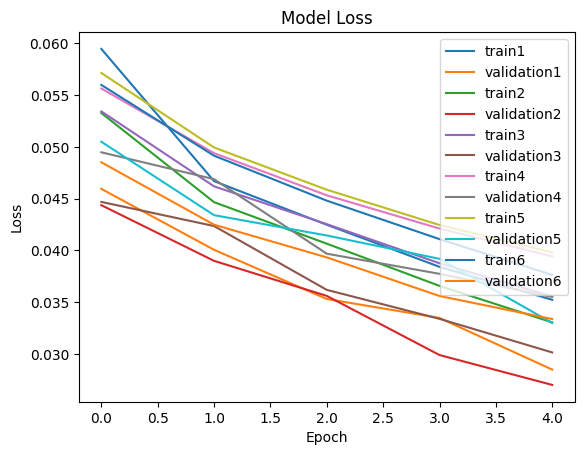

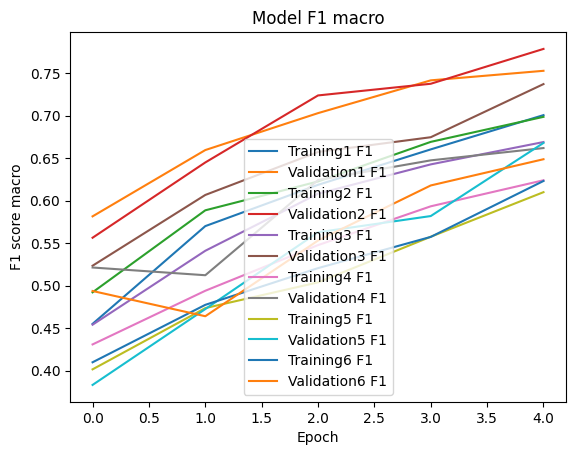

In [ ]:
# print("FOR 3 LAYERS:")
plt.plot(history1.history['loss'], label = "train1")
plt.plot(history1.history['val_loss'], label = "validation1")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train1', 'Validation1'], loc='upper right')
#plt.show()
# print("FOR 4 LAYERS:")
plt.plot(history2.history['loss'], label = "train2")
plt.plot(history2.history['val_loss'], label = "validation2")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train2', 'Validation2'], loc='upper right')
#plt.show()
# print("FOR 5 LAYERS:")
plt.plot(history3.history['loss'], label = "train3")
plt.plot(history3.history['val_loss'], label = "validation3")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train3', 'Validation3'], loc='upper right')
#plt.show()
# print("FOR 6 LAYERS:")
plt.plot(history4.history['loss'], label = "train4")
plt.plot(history4.history['val_loss'], label = "validation4")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train4', 'Validation4'], loc='upper right')
#plt.show()
# print("FOR 7 LAYERS:")
plt.plot(history5.history['loss'], label = "train5")
plt.plot(history5.history['val_loss'], label = "validation5")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.show()
# print("FOR 8 LAYERS:")
plt.plot(history6.history['loss'], label = "train6")
plt.plot(history6.history['val_loss'], label = "validation6")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


plt.plot(history1.history['f1_score'], label='Training1 F1')
plt.plot(history1.history['val_f1_score'], label='Validation1 F1')
plt.title('Model F1 macro')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
#plt.show()
plt.plot(history2.history['f1_score'], label='Training2 F1')
plt.plot(history2.history['val_f1_score'], label='Validation2 F1')
plt.title('Model F1 macro')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
#plt.show()
plt.plot(history3.history['f1_score'], label='Training3 F1')
plt.plot(history3.history['val_f1_score'], label='Validation3 F1')
plt.title('Model F1 macro')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
#plt.show()
plt.plot(history4.history['f1_score'], label='Training4 F1')
plt.plot(history4.history['val_f1_score'], label='Validation4 F1')
plt.title('Model F1 macro')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
#plt.show()
plt.plot(history5.history['f1_score'], label='Training5 F1')
plt.plot(history5.history['val_f1_score'], label='Validation5 F1')
plt.title('Model F1 macro')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
#plt.show()
plt.plot(history6.history['f1_score'], label='Training6 F1')
plt.plot(history6.history['val_f1_score'], label='Validation6 F1')
plt.title('Model F1 macro')
plt.xlabel('Epoch')
plt.ylabel('F1 score macro')
plt.legend()
plt.show()

As can be seen, two projection layers of 128 neurons leads to the highest the validation Macro F1-score as well as the steepest increase in Macro-F1 score with epochs/ fastest descent of loss with epochs. This implies that this is the optimum layer depth (with layer size invariant under depth differences). It is also interesting to note that just increasing the depth doesn't keep on improving preformance (quantified as validation F1- Scores), and for a certain use case, extensively deep networks may hurt performance rather than leading to performance gains.

**With two projection layers finalized, we move towards changing units (width)**

Now since the architecture optimal number of layers (embedding layer, bidirectional LSTM layer, ReLU layer, and then output layer) is chosen according to F1 score and loss, now we will vary the width (number of units) to see how wide or very narrow layers effect performance.

In [ ]:
with tf.device('/device:GPU:0'):
  tf.keras.backend.clear_session()
  model_glove1 = Sequential()
  model_glove1.add(embedding_layer)
  model_glove1.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
  model_glove1.add(Dense(128, activation='relu'))
  model_glove1.add(Dense(6, activation='sigmoid'))
  model_glove1.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
  model_glove1.summary()

  tf.keras.backend.clear_session()
  model_glove2 = Sequential()
  model_glove2.add(embedding_layer)
  model_glove2.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
  model_glove2.add(Dense(64, activation='relu'))
  model_glove2.add(Dense(6, activation='sigmoid'))
  model_glove2.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
  model_glove2.summary()

  tf.keras.backend.clear_session()
  model_glove3 = Sequential()
  model_glove3.add(embedding_layer)
  model_glove3.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
  model_glove3.add(Dense(32, activation='relu'))
  model_glove3.add(Dense(6, activation='sigmoid'))
  model_glove3.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
  model_glove3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         47616000  
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 48088966 (183.44 MB)
Trainable params: 472966 (1.80 MB)
Non-trainable params: 47616000 (181.64 MB)
_________________________________________________________________
Model: "sequential"
_______________________________________________________

**Training and plotting:**

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3988/3989 [============================>.] - ETA: 0s - loss: 0.0581 - f1_score: 0.4599WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x78aac624f7f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3989/3989 [==============================] - 135s 31ms/step - loss: 0.0581 - f1

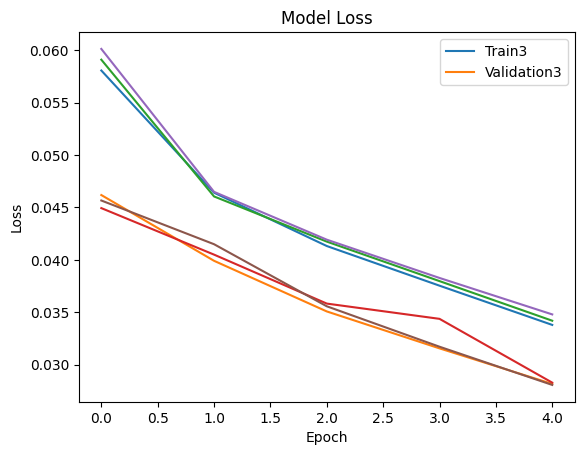

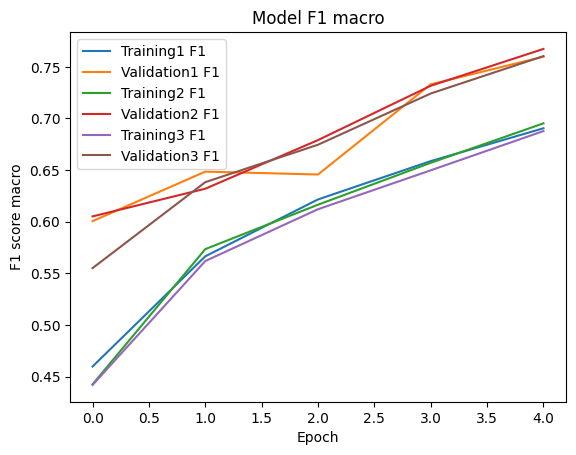

In [ ]:
with tf.device('/device:GPU:0'):
  history1 = model_glove1.fit(train, epochs=5, validation_data=val, callbacks = callbacks)
  history2 = model_glove2.fit(train, epochs=5, validation_data=val, callbacks = callbacks)
  history3 = model_glove3.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

  #plotting training loss
  plt.plot(history1.history['loss'], label = "train1")
  plt.plot(history1.history['val_loss'], label = "validation1")
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train1', 'Validation1'], loc='upper right')
  #plt.show()
  # print("FOR 4 LAYERS:")
  plt.plot(history2.history['loss'], label = "train2")
  plt.plot(history2.history['val_loss'], label = "validation2")
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train2', 'Validation2'], loc='upper right')
  #plt.show()
  # print("FOR 5 LAYERS:")
  plt.plot(history3.history['loss'], label = "train3")
  plt.plot(history3.history['val_loss'], label = "validation3")
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train3', 'Validation3'], loc='upper right')
  plt.show()

  #plotting f1 score
  plt.plot(history1.history['f1_score'], label='Training1 F1')
  plt.plot(history1.history['val_f1_score'], label='Validation1 F1')
  plt.title('Model F1 macro')
  plt.xlabel('Epoch')
  plt.ylabel('F1 score macro')
  plt.legend()
  #plt.show()
  plt.plot(history2.history['f1_score'], label='Training2 F1')
  plt.plot(history2.history['val_f1_score'], label='Validation2 F1')
  plt.title('Model F1 macro')
  plt.xlabel('Epoch')
  plt.ylabel('F1 score macro')
  plt.legend()
  #plt.show()
  plt.plot(history3.history['f1_score'], label='Training3 F1')
  plt.plot(history3.history['val_f1_score'], label='Validation3 F1')
  plt.title('Model F1 macro')
  plt.xlabel('Epoch')
  plt.ylabel('F1 score macro')
  plt.legend()
  #plt.show()


It can be seen that model 1 with the highest validation and training Macro-F1 Score is the most optimal option, perhaps due to the higher number of units it has (it is the widest model we designed). Further work is possible where we increase the width of the layers even more to observe overfitting effects. For now, however we will select this model and test it firstly, on the imbalanced testing set, and then train and evaluate the same model on balanced testing and training sets.

Raw datasets

In [ ]:
  tf.keras.backend.clear_session()
  model_glove = Sequential()
  model_glove.add(embedding_layer)
  model_glove.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
  model_glove.add(Dense(128, activation='relu'))
  model_glove.add(Dense(6, activation='sigmoid'))
  model_glove.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
  model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         46341000  
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 46813966 (178.58 MB)
Trainable params: 472966 (1.80 MB)
Non-trainable params: 46341000 (176.78 MB)
_________________________________________________________________


In [ ]:
  history= model_glove.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

Epoch 1/5
1995/1995 [==============================] - 83s 23ms/step - loss: 0.0607 - f1_score: 0.4406 - val_loss: 0.0477 - val_f1_score: 0.5791 - lr: 0.0010
Epoch 2/5
1995/1995 [==============================] - 44s 22ms/step - loss: 0.0470 - f1_score: 0.5651 - val_loss: 0.0419 - val_f1_score: 0.5984 - lr: 0.0010
Epoch 3/5
1995/1995 [==============================] - 42s 21ms/step - loss: 0.0430 - f1_score: 0.6076 - val_loss: 0.0382 - val_f1_score: 0.6159 - lr: 0.0010
Epoch 4/5
1995/1995 [==============================] - 44s 22ms/step - loss: 0.0393 - f1_score: 0.6371 - val_loss: 0.0337 - val_f1_score: 0.6927 - lr: 0.0010
Epoch 5/5
1995/1995 [==============================] - 45s 22ms/step - loss: 0.0361 - f1_score: 0.6771 - val_loss: 0.0297 - val_f1_score: 0.7450 - lr: 0.0010


In [ ]:
from sklearn.metrics import f1_score
list_tokenized_test = tokenizer.texts_to_sequences(test_set['comment_text'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')
Y_test = test_set.drop(columns='comment_text')
Y_test=Y_test.drop(Y_test.columns[0],axis=1)
test_metrics= model_glove.evaluate(X_test, Y_test)
test_auc = tf.keras.metrics.AUC()(Y_test, model_glove.predict(X_test))
test_accuracy=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy",threshold=0.5)(Y_test, model_glove.predict(X_test))
predictions = model_glove.predict(X_test)
predictions=[[1 if value > 0.5 else 0 for value in sublist] for sublist in predictions]
test_f1_score=f1_score(Y_test,predictions,average=None)
print(f'Test Accuracy: {test_accuracy:.4f}')
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for i in range(len(labels)):
  print(labels[i],":")
  print("F1 score:","%.6f"% (test_f1_score[i]*100),"%")
print(f'Test AUC: {test_auc:.4f}')

2000/2000 [==============================] - 40s 20ms/step
Test Accuracy: 0.9626
toxic :
F1 score: 58.487375 %
severe_toxic :
F1 score: 35.130971 %
obscene :
F1 score: 58.538877 %
threat :
F1 score: 40.414508 %
insult :
F1 score: 58.684091 %
identity_hate :
F1 score: 48.453608 %
Test AUC: 0.9446


Balanced datasets

In [ ]:
def get_embedding_matrix(length_voc, word_index, embedding_dim = 300):
    num_tokens = length_voc + 1
    embedded = []
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        if not(word in embedded):
            try:
                embedding_vector = glove.get_vector(word)
                embedding_matrix[i] = embedding_vector
            except:
                embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                embedded.append(word)

    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_train['comment_text'])
word_index_train = tokenizer.word_index
embedding_matrix_train = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
embedding_dim = glove.vectors.shape[1]

print(len(word_index_train.keys()))
NUM_FEATURES = len(word_index_train)
list_tokenized_train = tokenizer.texts_to_sequences(balanced_train['comment_text'])
lengths = balanced_train['comment_text'].str.split().apply(len)
MAX_LENGTH = 100
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LENGTH, padding = 'post')
Y_train = balanced_train.drop(columns='comment_text')
Y_train=Y_train.drop(Y_train.columns[0],axis=1).values
train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_set = train_set.cache()
train_set = train_set.shuffle(100000)
train_set = train_set.batch(64)
train = train_set.take(int(0.8*len(train_set)))
val = train_set.skip(int(0.8*len(train_set))).take(int(0.2*len(train_set)))

70328


In [ ]:
  tf.keras.backend.clear_session()
  model_glove = Sequential()
  model_glove.add(embedding_layer)
  model_glove.add(Bidirectional(LSTM(128, dropout=0.2, activation='tanh')))
  model_glove.add(Dense(128, activation='relu'))
  model_glove.add(Dense(6, activation='sigmoid'))
  model_glove.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics = [tfa.metrics.F1Score(num_classes=6, average='macro', threshold=0.5)])
  model_glove.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         46341000  
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 46813966 (178.58 MB)
Trainable params: 472966 (1.80 MB)
Non-trainable params: 46341000 (176.78 MB)
_________________________________________________________________


In [ ]:
history= model_glove.fit(train, epochs=5, validation_data=val, callbacks = callbacks)

Epoch 1/5
573/573 [==============================] - 24s 28ms/step - loss: 0.2230 - f1_score: 0.3300 - val_loss: 0.1621 - val_f1_score: 0.4258 - lr: 0.0010
Epoch 2/5
573/573 [==============================] - 14s 24ms/step - loss: 0.1606 - f1_score: 0.4733 - val_loss: 0.1343 - val_f1_score: 0.4933 - lr: 0.0010
Epoch 3/5
573/573 [==============================] - 11s 19ms/step - loss: 0.1362 - f1_score: 0.5514 - val_loss: 0.1164 - val_f1_score: 0.6241 - lr: 0.0010
Epoch 4/5
573/573 [==============================] - 13s 23ms/step - loss: 0.1211 - f1_score: 0.5927 - val_loss: 0.0986 - val_f1_score: 0.6814 - lr: 0.0010
Epoch 5/5
573/573 [==============================] - 22s 38ms/step - loss: 0.1093 - f1_score: 0.6478 - val_loss: 0.0883 - val_f1_score: 0.7204 - lr: 0.0010


In [ ]:
from sklearn.metrics import f1_score
list_tokenized_test = tokenizer.texts_to_sequences(balanced_test['comment_text'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LENGTH, padding = 'post')
Y_test = balanced_test.drop(columns='comment_text')
Y_test=Y_test.drop(Y_test.columns[0],axis=1)
test_metrics= model_glove.evaluate(X_test, Y_test)
test_auc = tf.keras.metrics.AUC()(Y_test, model_glove.predict(X_test))
test_accuracy=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy",threshold=0.5)(Y_test, model_glove.predict(X_test))
predictions = model_glove.predict(X_test)
predictions=[[1 if value > 0.5 else 0 for value in sublist] for sublist in predictions]
test_f1_score=f1_score(Y_test,predictions,average=None)
print(f'Test Accuracy: {test_accuracy:.4f}')
labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for i in range(len(labels)):
  print(labels[i],":")
  print("F1 score:","%.6f"% (test_f1_score[i]*100),"%")
print(f'Test AUC: {test_auc:.4f}')

1147/1147 [==============================] - 25s 21ms/step
Test Accuracy: 0.9205
toxic :
F1 score: 55.104074 %
severe_toxic :
F1 score: 30.769231 %
obscene :
F1 score: 51.769424 %
threat :
F1 score: 30.994152 %
insult :
F1 score: 56.007493 %
identity_hate :
F1 score: 43.033510 %
Test AUC: 0.9267


#Results:
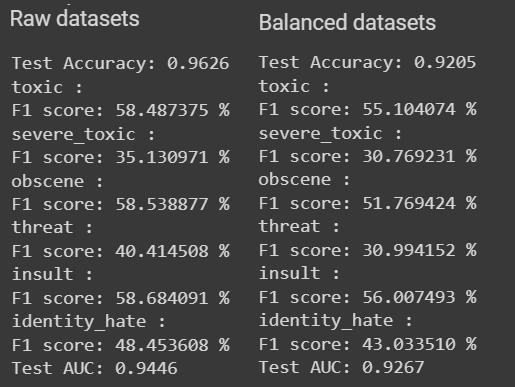

It is interesting to see that this model works better on unbalanced, raw training and test datasets than smaller (~4x smaller) balanced train and test datasets. This may be beacuse complex models like bi-LSTMs, being capable of capturing sequential dependencies, may benefit from the unbalanced dataset by learning more intricate patterns and representations present in the majority class.The unbalanced dataset is a better representation of the true distribution of the data in the real-world scenario and the samples we have made might not be well-curated as they were based on random sampling (indeed our balanced sets our not really balanced, they reflect the imbalances within the toxic categories, albeit diminish the divide between toxic and non-toxic proportions). Regardless, there is a suggestion, at the very least, that such complex models work better on large amounts of data, be they balanced or imbalanced, compared to much smaller amounts of relatively balanced datasets. Consequently, we will not utilize any balancing techniques in our next model, which finetunes a pretrained BERT model and adapts it to a toxicity analysis use case by training it on the given (unbalanced) training dataset.